## Uncertainty analysis - US Landscapes
- Cell2Fire simulations of real landscape in the US (Near Santa Barbara, CA)
- Comparison of Cell2Fire and Prometheus simulation outputs
- Comparison of Cell2Fire vs. Cell2Fire with BBO
- Uncertainty analysis of adjustment factors (HROS, BROS, FROS, Eccentricity, Fire period length)
    - Initial grid search + fine-tuned grid search --> Model calibration 
    - Burn probability of Cell2Fire and Cell2Fire with BBO simulations (aggregated from 1K samples)
    - Uncertainty analysis results show variance (i.e., worst, average, best results)
- Optimization (using Optuna)

In [1]:
# Libraries
import os, random, time, subprocess, glob, tqdm
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional
from random import randint
import rasterio

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

# C2F
import utils.DataGeneratorC2 as DataGenerator

# Metrics
from numpy import linalg as LA
from sklearn.metrics import f1_score, r2_score
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        DataGenerator.GenDataFile(args.InFolder)    
                    
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--sim', str(args.Simulator),
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
               '--mcnumber', str(args.mcnumber),
            #    '--scenario' if str(args.scenario) else '',
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--EllipticalOption', str(args.EllipticalOption),
               '--LBFormula', str(args.LBFormula),
               '--kopt' if (args.KOPT) else '',
               '--verbose' if (args.verbose) else '',]


    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # # End of the replications
    # print("End of Cell2FireC execution...")

In [3]:
'''
Metrics:
- ADI
- Sorensen index (Dice)
- F1-score
'''

def compute_ADI(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_farsite = result_farsite.flatten()        

    # Intersection (I) - Cells burned in both models
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Overestimation (OE) - Burned in Cell2Fire but NOT in FARSITE
    overestimation = np.sum((result_c2f == 1) & (result_farsite == 0))

    # Underestimation (UE) - Burned in FARSITE but NOT in Cell2Fire
    underestimation = np.sum((result_c2f == 0) & (result_farsite == 1))

    # Calculate ADI (Area Difference Index)
    ADI = (overestimation + underestimation) / intersection         # ADI (Area Difference Index)
    ADIue = underestimation / intersection                          # ADIue (Underestimation Index)
    ADIoe = overestimation / intersection                           # ADIoe (Overestimation Index)

    # Edge effect
    if intersection == 0:
        ADI, ADIue, ADIoe = np.nan, np.nan, np.nan
        # print("No overlap between the predicted and observed fire perimeters. ADI metrics cannot be calculated.")

    return ADI, ADIue, ADIoe


def compute_sorensen(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_farsite = result_farsite.flatten()        

    # Calculate intersection (correctly predicted burned area)
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Calculate total burned areas
    area_cell2fire = np.sum(result_c2f == 1)
    area_farsite = np.sum(result_farsite == 1)

    # Sorensen-Dice Index (SDI) Calculation
    if (area_cell2fire + area_farsite) == 0:
        SDI = np.nan  # Avoid division by zero if no burned area in both grids
    else:
        SDI = (2 * intersection) / (area_cell2fire + area_farsite)

    return SDI

def compute_f1_score(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_farsite = result_farsite.flatten()        

    # Define burned and unburned regions
    # 1 = burned, 0 = unburned
    burned_cell2fire = (result_c2f == 1).astype(int)
    burned_farsite = (result_farsite == 1).astype(int)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((burned_cell2fire == 1) & (burned_farsite == 1))  # Correctly predicted burned
    FP = np.sum((burned_cell2fire == 1) & (burned_farsite == 0))  # Overestimated (False Positive)
    FN = np.sum((burned_cell2fire == 0) & (burned_farsite == 1))  # Underestimated (False Negative)

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if (precision + recall) == 0:
        F1 = 0  # Avoid division by zero
    else:
        F1 = (2 * precision * recall) / (precision + recall)

    return F1, precision, recall

In [4]:
# Basic parameters and paths
BASE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/'
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireW/')         # Cell2Fire binary
FARSITE_PATH = os.path.join(BASE_PATH, 'data/farsite')
DATA_PATH = os.path.join(BASE_PATH, 'data/real')
OUTPUT_PATH = os.path.join(DATA_PATH, 'us_sensitivity')

# Create output folder for MC-sampled simulation results
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

## 1. Initial tune

In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'Sherpa_10H'
N_THREADS = 1
sim = 'US'

# C2F Parameters
_HFactor = np.arange(0, 3, 0.5)
_BFactor = np.arange(0, 3, 0.5)
_FFactor = np.arange(0, 3, 0.5)
_EFactor = np.arange(0, 1, 0.5)
_fperiod = [1,2]

Run Cell2Fire simulations using the adjustment factor and fire period length values

## 2. Fine-tune

In [5]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'Sherpa_10H'
N_THREADS = 1
sim = 'US'

# C2F Parameters
_HFactor = np.arange(0.9, 1.1, 0.1)
_BFactor = np.arange(0.5, 1.5, 0.1)
_FFactor = np.arange(0.5, 1.5, 0.1)
_EFactor = np.arange(0.5, 1, 0.1)
_fperiod = [1,2]

#### Grid search using fine-tuned bounds
- Run Cell2Fire simulations for all fine-tuned adjustment factor combinations
- Iterate for all hours (i.e., 10 hours total)
- Keep optimization options off (KOPT and BBO)

***KOPT: Multi-objective optimization using elliptical parameters based on Ghisu et al. (2015)


Ghisu, T., Arca, B., Pellizzaro, G., & Duce, P. (2015). An optimal Cellular Automata algorithm for simulating wildfire spread. Environmental Modelling & Software, 71, 1-14.

In [29]:
# Loop through every hour of the fire progression (This takes a long time...)
for hour in np.arange(1, 11,1):
    print("=="*30)
    print("INSTANCE: {}H".format(hour))
    
    with tqdm.tqdm(total=len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod), 
            desc="Running...") as pbar:

        # Input instance
        INSTANCE = "Sherpa_{}H".format(hour)
        INSTANCE_PATH = os.path.join(DATA_PATH, INSTANCE)

        # Create placeholders
        results = {"Instance":[], "HFactor":[], "BFactor":[], "FFactor":[], "EFactor":[], "fperiod":[],
                "ADI":[], "ADI_ue":[], "ADIoe":[], "F1":[], 'RMSE':[], 'R2':[],
                "norm":[], "MSE":[], "area_c2f":[], "SSIM":[], "area_farsite":[], "time":[]
                }
        cnt = 0

        # Load reference dataset (FarSite)
        df_farsite = rasterio.open(os.path.join(FARSITE_PATH, INSTANCE + '.tif')).read(1)
        df_farsite[df_farsite<=0] = 0
        df_farsite[df_farsite>0] = 1

        # Loop
        for HFactor in _HFactor:
            for BFactor in _BFactor:
                for FFactor in _FFactor:
                    for EFactor in _EFactor:
                        for fperiod in _fperiod:
            
                            OUT_PATH = os.path.join(OUTPUT_PATH, "sensitivity" + str(cnt))
                            
                            # Cell2Fire options
                            args = {
                                'InFolder': INSTANCE_PATH,
                                'OutFolder': OUT_PATH,
                                'ignitions': True,
                                'sim_years': 1,
                                'sim': str(sim),
                                'nsims': 1,
                                'mcnumber': cnt,
                                'Simulator': 'US',
                                'grids': False, 
                                'finalGrid': True,
                                'input_PeriodLen': fperiod,
                                'OutMessages': False,
                                'WeatherOpt': 'rows',
                                'nweathers': 1,
                                'ROS_CV': 0.0,
                                'IgRadius': 0, 
                                'seed': 123,
                                'ROS_Threshold':0.0,
                                'HFI_Threshold':0.0,
                                'HFactor':HFactor,
                                'BFactor':BFactor,
                                'FFactor':FFactor,
                                'EFactor':EFactor,
                                'nthreads':N_THREADS,
                                'BBO': False,
                                'HCells': None,
                                'verbose': False,
                                'EllipticalOption':1, 
                                'LBFormula':0, 
                                'KOPT':False,
                                'verbose':False
                            }

                            # Convert to object
                            args_obj = Dict2Class(args)
                    
                            # Execution
                            start_time = time.time()
                            run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
                            end_time = time.time()
                            execution_time = end_time - start_time

                            # Load simulated and reference outputs
                            df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
                            df_result_npy = df_result.to_numpy().flatten()

                            # Compute evaluation metrics
                            ADI, ADIue, ADIoe = compute_ADI(df_result, df_farsite)
                            # F1, precision, recall = compute_f1_score(df_result, df_farsite)


                            norm = LA.norm(df_result_npy - df_farsite.flatten())
                            mse = ((df_result_npy - df_farsite.flatten())**2).mean()
                            F1 = f1_score(df_farsite.flatten() , df_result_npy, average='macro')
                            ssim_sc = ssim(df_result_npy, df_farsite.flatten(), data_range=1)
                            r2_sc = r2_score(df_result_npy, df_farsite.flatten())
                            area_cell2fire = len(df_result_npy[df_result_npy == 1])
                            area_farsite = len(df_farsite[df_farsite == 1])

                            results['Instance'].append(cnt)
                            results['HFactor'].append(HFactor)
                            results['BFactor'].append(BFactor)
                            results['FFactor'].append(FFactor)
                            results['EFactor'].append(EFactor)
                            results['fperiod'].append(fperiod)
                            results['ADI'].append(ADI)
                            results['ADI_ue'].append(ADIue)
                            results['ADIoe'].append(ADIoe)
                            results['F1'].append(F1)
                            results['norm'].append(norm)
                            results['MSE'].append(mse)
                            results['RMSE'].append(np.sqrt(mse))
                            results['SSIM'].append(ssim_sc)
                            results['R2'].append(r2_sc)
                            results['area_farsite'].append(area_farsite)
                            results['area_c2f'].append(area_cell2fire)
                            
                            # results['Precision'].append(precision)
                            # results['Recall'].append(recall)
                            results['time'].append(0)                    

                            cnt+=1
                            pbar.update(1)

        # Save  
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(OUTPUT_PATH, 'all_results_sensitivity_{}_r2.csv'.format(INSTANCE))) # Save to file

results_df = pd.DataFrame(results)        

INSTANCE: 1H


Running...: 100%|██████████| 3000/3000 [57:26<00:00,  1.15s/it]  


INSTANCE: 2H


Running...: 100%|██████████| 3000/3000 [1:31:17<00:00,  1.83s/it]


INSTANCE: 3H


Running...: 100%|██████████| 3000/3000 [1:09:29<00:00,  1.39s/it]


INSTANCE: 4H


Running...: 100%|██████████| 3000/3000 [1:01:58<00:00,  1.24s/it]


INSTANCE: 5H


Running...: 100%|██████████| 3000/3000 [1:25:30<00:00,  1.71s/it]


INSTANCE: 6H


Running...: 100%|██████████| 3000/3000 [2:16:54<00:00,  2.74s/it]  


INSTANCE: 7H


Running...: 100%|██████████| 3000/3000 [2:28:31<00:00,  2.97s/it]  


INSTANCE: 8H


Running...: 100%|██████████| 3000/3000 [2:10:45<00:00,  2.62s/it]  


INSTANCE: 9H


Running...: 100%|██████████| 3000/3000 [2:35:11<00:00,  3.10s/it]  


INSTANCE: 10H


Running...: 100%|██████████| 3000/3000 [3:02:44<00:00,  3.65s/it]  


#### Uncertainty analysis results
- Error bars (Updated for Fig. 3)
- Adjustment factor range and influence on evaluation metric (i.e., F1-score)
- Discrepancy of Cell2Fire simulations vs. real burn scar (Worst, average, best)

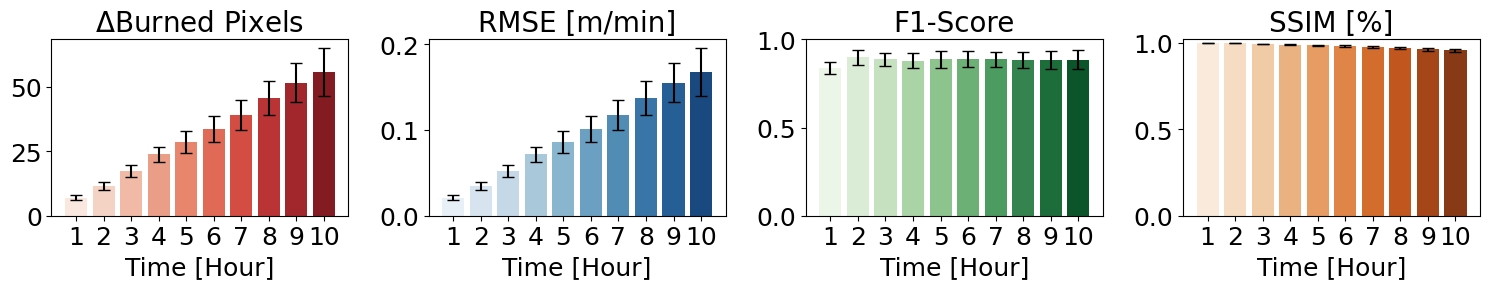

In [34]:
# Load all CSV files
fpaths = sorted(glob.glob(os.path.join(OUTPUT_PATH, 'all_results_sensitivity_*_r2*.csv')))  # Saved results from "Grid search using fine-tuned bounds"
file_paths = sorted(fpaths, key=lambda x: int(x.split('_Sherpa_')[1].split('H')[0]))
dfs = [pd.read_csv(f) for f in file_paths]

# Combine into one DataFrame with 'hour' as a new column
for i, df in enumerate(dfs):
    df["hour"] = i + 1  # Assign hour (1 to 9)
df_all = pd.concat(dfs, ignore_index=True)

# Define error metrics
metrics = ["norm", "RMSE", "F1", "SSIM"]
cmaps = ['Reds', 'Blues', 'Greens', 'Oranges']
titles = ['$\Delta$Burned Pixels', 'RMSE [m/min]', 'F1-Score', 'SSIM [%]']

# Plot each metric with error bars
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
ax = axs.flatten()

# Plot for each metric
for idx, (metric, cmap, title) in enumerate(zip(metrics, cmaps, titles)):
    # Group by hour & compute mean and standard deviation
    grouped = df_all.groupby("hour")[metric].agg(["mean", "std"]).reset_index()
    
    bars = sns.barplot(
        x="hour", y="mean", data=grouped,
        errorbar=("ci", 0),  # disables automatic CI bar
        ax=ax[idx],
        palette=cmap,
        capsize=0.2
    )

    # Add your custom error bars manually
    ax[idx].errorbar(
        x=np.arange(len(grouped)),
        y=grouped["mean"],
        yerr=grouped["std"],
        fmt='none',
        capsize=4,
        color='black'
    )

    
    # Get the x-coordinates of the bars
    x_coords = [p.get_x() + p.get_width()/2 for p in ax[idx].patches]
    
    # # Add error bars based on standard deviation of fine-tuned grid search results
    # ax[idx].errorbar(
    #     x=x_coords,
    #     y=grouped["mean"],
    #     yerr=grouped["std"],
    #     fmt='none',
    #     capsize=5,
    #     capthick=1,
    #     # elinewidth=1,
    #     color='black',
    #     ecolor='black',
    #     alpha=0.25
    # )
    
    # Format for each subplot
    ax[idx].set_xlabel("Time [Hour]", size=18)
    ax[idx].set_ylabel('')
    ax[idx].set_title(f"{title}", size=20)
    ax[idx].set_xticks(range(len(grouped)))
    ax[idx].set_xticklabels(grouped["hour"])
    ax[idx].tick_params(axis='both', labelsize=18)
    
    # Set y-axis limits for better viz
    if metric == "F1":
        ax[idx].set_ylim([0, 1])
    elif metric == "SSIM":
        ax[idx].set_ylim([0, 1.02])

# Adjust layout
plt.tight_layout()
plt.show()

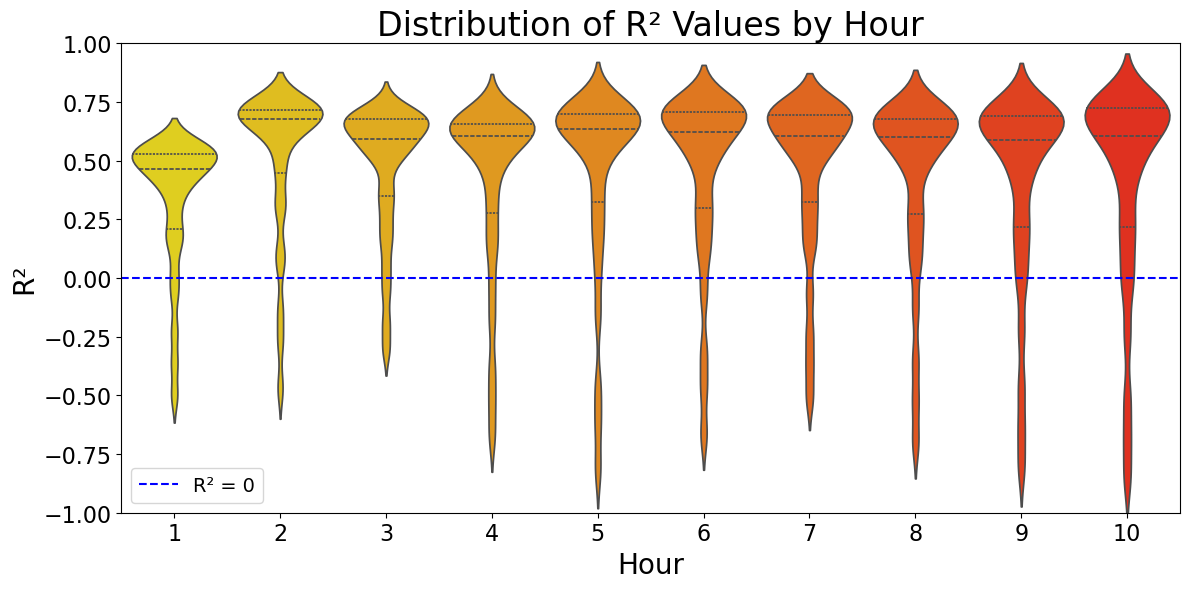

In [43]:
# Combine datasets
dfs = []
for path in file_paths:
    hour = int(os.path.basename(path).split('_')[4].replace('H', ''))
    df = pd.read_csv(path)
    df['avg_r2'] = df['R2'].mean()
    df['hour'] = hour
    dfs.append(df)

# Concatenate all into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Plot violin plot
fig, ax = plt.subplots(1, figsize=(12, 6))
# sns.lineplot(ax=ax, data=results_df, x='hour', y='avg_r2')
sns.violinplot(ax=ax, data=combined_df, x='hour', y='R2', inner='quartile', palette='autumn_r')
# sns.stripplot(ax=ax, data=combined_df, x='hour', y='avg_r2', alpha=0.5, jitter=False, color='k')

ax.axhline(0, linestyle='--', color='blue', label='R² = 0')
ax.set_title('Distribution of R² Values by Hour', size=24)

ax.set_ylim([-1,1])
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Hour', size=20)
ax.set_ylabel('R²', size=20)
ax.legend(loc='lower left', fontsize=14)
plt.tight_layout()
plt.show()

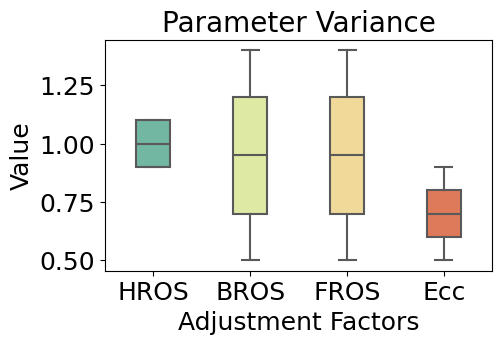

In [184]:
# Adjustment factor influence on F1-Score
fig, ax = plt.subplots(1, figsize=(5, 3))

df_melted = results_df.melt(id_vars=['F1'], 
                            value_vars=["HFactor", "BFactor", "FFactor", "EFactor"],
                            var_name="Factor", value_name="Value")

sns.boxplot(x="Factor", y="Value", data=df_melted, width=0.35, palette='Spectral_r')

ax.set_title("Parameter Variance", size=20)
ax.set_ylabel("Value",size=18)
ax.set_xticklabels(['HROS', 'BROS', 'FROS', 'Ecc'])
ax.set_xlabel("Adjustment Factors",size=18)
ax.tick_params(axis='both', labelsize=18)
plt.show()


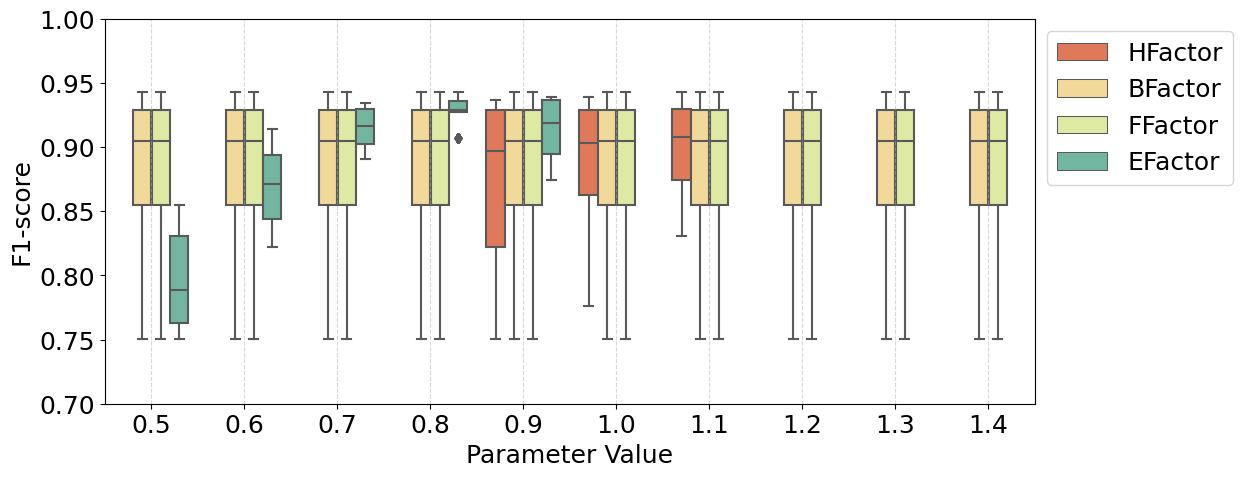

In [346]:
# Range of adjustment factor values vs. F1-Score values
df = results_df[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'F1']]
df.iloc[:, :-1] = df.iloc[:, :-1].round(1)  # Round all columns except 'F1'

fig, ax = plt.subplots(1, figsize=(12,5))

df_melted = df.melt(id_vars="F1", var_name="Factor", value_name="Factor Value")

# Convert to categorical to maintain order
df_melted["Factor Value"] = df_melted["Factor Value"]

sns.boxplot(x="Factor Value", y="F1", hue="Factor", palette='Spectral', data=df_melted, ax=ax)

ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Parameter Value", size=18)
ax.set_ylabel("F1-score", size=18)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 18})

# Align grid with categorical x-axis labels
ax.set_xticks(range(len(df_melted["Factor Value"].unique())))
ax.set_xticklabels(sorted(df_melted["Factor Value"].unique()))  # Ensure order
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.ylim([0.7, 1])
plt.show()


#### Discrepancy analysis

In [432]:
# Get parameters for worst, average, best simulations (By F1-score)
worst_params = results_df.sort_values(by='F1')[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'fperiod', 'F1']].iloc[0].to_frame().T
avg_params = results_df[results_df['F1'] >= results_df['F1'].mean()].sort_values(by='F1').iloc[0:1]
best_params = results_df.sort_values(by='F1', ascending=False)[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'fperiod', 'F1']].iloc[0].to_frame().T

In [470]:
worst_params

,HFactor,BFactor,FFactor,EFactor,fperiod,F1
541,0.9,1.0,0.9,0.5,2.0,0.750114


In [472]:
avg_params

,Instance,HFactor,BFactor,FFactor,EFactor,fperiod,ADI,ADI_ue,ADIoe,F1,norm,MSE,area_c2f,SSIM,area_farsite,time
635,635,0.9,1.1,0.8,0.7,2,0.511717,0.494579,0.017139,0.891055,54.092513,0.026476,5816,0.959439,8546,2.725675


In [473]:
best_params

,HFactor,BFactor,FFactor,EFactor,fperiod,F1
2967,1.1,1.4,1.1,0.8,2.0,0.94296


In [433]:
all_params = [worst_params, avg_params, best_params]

#### Best results from uncertainty analysis for the US real landscape

In [448]:
OUT_PATH = os.path.join(OUTPUT_PATH, 'opt_temp')
recorded_results = []

for row in [worst_params, avg_params, best_params]:

    # Cell2Fire options
    args = {
        'InFolder': INSTANCE_PATH,
        'OutFolder': OUT_PATH,
        'ignitions': True,
        'sim_years': 1,
        'sim': str(sim),
        'nsims': 1,
        'mcnumber': 0,
        'Simulator': 'US',
        'grids': False,
        'finalGrid': True,
        'input_PeriodLen': 1.0,
        'OutMessages': False,
        'WeatherOpt': 'rows',
        'nweathers': 1,
        'ROS_CV': 0.0,
        'IgRadius': 0,
        'seed': 123,
        'ROS_Threshold': 0.0,
        'HFI_Threshold': 0.0,
        'HFactor': 1.0,
        'BFactor': 1.0,
        'FFactor': 1.0,
        'EFactor': 1.0,
        'nthreads': N_THREADS,
        'BBO': False,
        'HCells': None,
        'verbose': False,
        'EllipticalOption': 1,
        'LBFormula': 0,
        'KOPT': False,
        'verbose': False
    }

    # Convert to object and run
    args['HFactor'] = row['HFactor'].values[0]
    args['FFactor'] = row['FFactor'].values[0]
    args['BFactor'] = row['BFactor'].values[0]
    args['EFactor'] = row['EFactor'].values[0]
    args['input_PeriodLen'] = row['fperiod'].values[0]

    args_obj = Dict2Class(args)
    start_time = time.time()
    run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
    end_time = time.time()

    # Load simulated output
    df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
    recorded_results.append(df_result)

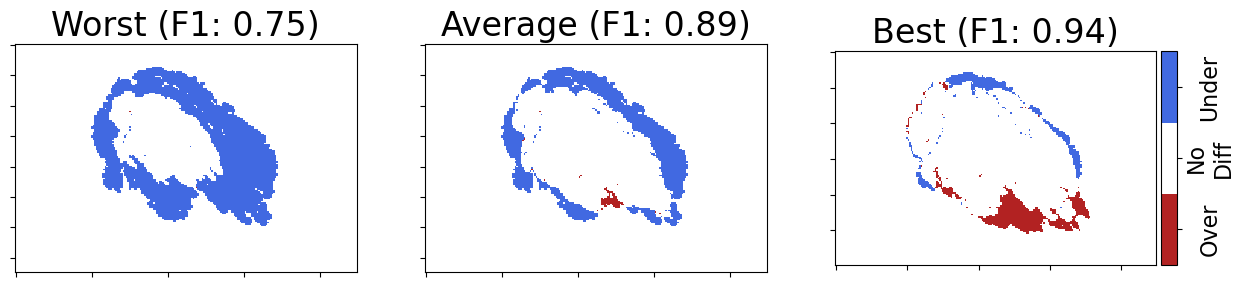

In [492]:
# Plot best result (by F1)
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

label_size = 16
scale_size = 30
scale_length_fraction = 0.15
tick_label_size = 16

# Plot
fig, ax = plt.subplots(1,3, figsize=(15,5))

scalebar = ScaleBar(scale_size, 'm', length_fraction=scale_length_fraction, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": label_size})
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

for i, (_df, title, params) in enumerate(zip(recorded_results, ['Worst', 'Average', 'Best'], all_params)):
    diff = df_farsite[:150, 50:275] - _df.values[:150, 50:275]
    im = ax[i].imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
    # ax[i].add_artist(scalebar)
    ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
    ax[i].set_title("{} (F1: {:.2f})".format(title, params['F1'].values[0]), size=24)


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No\nDiff','Over'],size=label_size, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

plt.tight_layout
plt.show()

#### Sensitivity analysis
- Spearman Correlation Coefficient (SPCC)

In [464]:
from affine import Affine
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon

def convert_to_shp(matrix):
    # Convert the matrix to a GeoDataFrame
    rows, cols = matrix.shape
    polygons = []

    transform = Affine.translation(0, rows) * Affine.scale(1, -1)  # Flip the y-axis

    # Loop over matrix values
    for i in range(rows):
        for j in range(cols):
            value = matrix[i, j]
            x, y = transform * (j, i)

            polygon = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])  # Adjusted with the transformation
            polygons.append((polygon, value))  # Store the polygon and its value

    # Create a GeoDataFrame from the polygons
    crs = 'EPSG:3857'  # Set the coordinate reference system (WGS84)
    gdf = gpd.GeoDataFrame(polygons, columns=['geometry', 'value'], crs=crs)

    # Dissolve the individual polygons into a single polygon based on value
    dissolved_gdf = gdf.dissolve(by='value').reset_index(drop=True)
    final_gdf = gpd.GeoDataFrame(geometry=[dissolved_gdf.loc[1].geometry])
    
    return final_gdf

In [467]:
# Get vector shapefiles
min_c2f_shp = convert_to_shp(np.asarray(recorded_results[0]))
avg_c2f_shp = convert_to_shp(np.asarray(recorded_results[1]))
max_c2f_shp = convert_to_shp(np.asarray(recorded_results[2]))

In [469]:
ref_shp = convert_to_shp(np.asarray(df_farsite))

#### Uncertainty using variance

In [496]:
from scipy.stats import spearmanr, f_oneway

result_metrics = ['ADI', 'RMSE', 'F1']
sens_df = pd.DataFrame(columns=["Factor", "Metric", "SPCC", "SPCC_P_value"])

for var in ['HFactor', 'BFactor', 'FFactor', 'EFactor', 'fperiod']:
    print("==" * 50)
    print(var)

    for col in result_metrics:
        # SPCC
        spearman_corr, p_value_spcc = spearmanr(results_df[var], results_df[col])

        # Print results
        print(f"[{col}] SPCC: {spearman_corr:.4f}, P-value: {p_value_spcc:.4e}")

        # Append to DataFrame
        sens_df.loc[len(sens_df)] = [
            var, col, spearman_corr, p_value_spcc, 
        ]

HFactor
[ADI] SPCC: -0.1604, P-value: 9.8117e-19
[RMSE] SPCC: -0.0613, P-value: 7.7882e-04
[F1] SPCC: 0.1604, P-value: 9.8117e-19
BFactor
[ADI] SPCC: 0.0000, P-value: 1.0000e+00
[RMSE] SPCC: 0.0000, P-value: 1.0000e+00
[F1] SPCC: 0.0000, P-value: 1.0000e+00
FFactor
[ADI] SPCC: 0.0000, P-value: 1.0000e+00
[RMSE] SPCC: 0.0000, P-value: 1.0000e+00
[F1] SPCC: 0.0000, P-value: 1.0000e+00
EFactor
[ADI] SPCC: -0.7353, P-value: 0.0000e+00
[RMSE] SPCC: -0.5664, P-value: 3.5098e-254
[F1] SPCC: 0.7325, P-value: 0.0000e+00
fperiod
[ADI] SPCC: -0.0963, P-value: 1.2676e-07
[RMSE] SPCC: -0.1579, P-value: 3.3369e-18
[F1] SPCC: 0.0963, P-value: 1.2676e-07


## 3. Model calibration using Optuna
- Optimize adjustment factor by evaluation metric (or some tolerance interval, $\epsilon$)
    - Objective: Maximize F1-score
    - Iterations: 100 trials
    - Parameter space: Bounds from fine-tuned grid search

Ex: Best parameters: HROS: 1.1, BROS: 1.4, FROS: 1.1, Eccentricity: 0.8, Fire period length: 2.0	
100 trials to optimize maximum F1-score using sample parameter space with smaller intervals ~ 40 min

In [509]:
import optuna

def objective(trial):
    """Optuna objective function to optimize Cell2Fire parameters."""

    # Example parameters from Optuna --> Modify to fine-tuned parameter bounds
    HFactor = trial.suggest_float("HFactor", 1, 1.2) 
    BFactor = trial.suggest_float("BFactor", 1.3, 1.5)
    FFactor = trial.suggest_float("FFactor", 1.0, 1.2)
    EFactor = trial.suggest_float("EFactor", 0.7, 0.9)
    fperiod = trial.suggest_int("fperiod", 1.9, 2.1)

    OUT_PATH = os.path.join(OUTPUT_PATH, str(trial.number))
    
    # Cell2Fire options
    args = {
        'InFolder': INSTANCE_PATH,
        'OutFolder': OUT_PATH,
        'ignitions': True,
        'sim_years': 1,
        'sim': str(sim),
        'nsims': 1,
        'mcnumber': trial.number,
        'Simulator': 'US',
        'grids': False,
        'finalGrid': True,
        'input_PeriodLen': fperiod,
        'OutMessages': False,
        'WeatherOpt': 'rows',
        'nweathers': 1,
        'ROS_CV': 0.0,
        'IgRadius': 0,
        'seed': 123,
        'ROS_Threshold': 0.0,
        'HFI_Threshold': 0.0,
        'HFactor': HFactor,
        'BFactor': BFactor,
        'FFactor': FFactor,
        'EFactor': EFactor,
        'nthreads': N_THREADS,
        'BBO': False,
        'HCells': None,
        'verbose': False,
        'EllipticalOption': 1,
        'LBFormula': 0,
        'KOPT': False,
        'verbose': False
    }

    # Convert to object and run
    args_obj = Dict2Class(args)
    start_time = time.time()
    run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
    end_time = time.time()

    # Load simulated output
    try:
        df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
        df_result_npy = df_result.to_numpy().flatten()

        # Compute evaluation metrics
        norm = LA.norm(df_result_npy - df_farsite.flatten())
        mse = ((df_result_npy - df_farsite.flatten()) ** 2).mean()
        F1 = f1_score(df_farsite.flatten(), df_result_npy, average='macro')
        ssim_sc = ssim(df_result_npy, df_farsite.flatten(), data_range=1)

        # Metric to optimize (Minimize MSE or maximize F1)
        return F1  # Or use `-F1` for maximization or `1 - SSIM`
    
    except Exception as e:
        print(f"Error processing trial {trial.number}: {e}")
        return float('-inf')  # Penalize if error occurs

# Input instance
all_results_df = {'instance':[], 'HROS':[], 'FROS':[], 'BROS':[], 'Ecc':[], 'FPeriod':[], 'F1':[]}

for idx, hour in tqdm.tqdm(enumerate(np.arange(1, 11, 1)), total=10, desc='Processing...'):

    INSTANCE = 'sherpa_' + str(hour) + 'H'
    INSTANCE_PATH = os.path.join(DATA_PATH, INSTANCE)

    # Load reference dataset (FarSite)
    df_farsite = rasterio.open(os.path.join(FARSITE_PATH, INSTANCE + '.tif')).read(1)
    df_farsite[df_farsite <= 0] = 0
    df_farsite[df_farsite > 0] = 1

    # Run Optuna optimization
    study = optuna.create_study(direction="maximize")  # Or direction="maximize" for F1/SSIM
    study.optimize(objective, n_trials=100, n_jobs=N_THREADS)

    # Get best parameters
    all_results_df['instance'].append(hour)
    all_results_df['HROS'].append(study.best_params['HFactor'])
    all_results_df['BROS'].append(study.best_params['BFactor'])
    all_results_df['FROS'].append(study.best_params['FFactor'])
    all_results_df['Ecc'].append(study.best_params['EFactor'])    
    all_results_df['FPeriod'].append(study.best_params['fperiod'])
    all_results_df['F1'].append(study.best_value)
    
    # print(f"Best parameters: {study.best_params}")
    # print(f"Best value: {study.best_value}")

    # Save results
    study.trials_dataframe().to_csv(os.path.join(OUTPUT_PATH, 'optuna_results_{}.csv'.format(INSTANCE)), index=False)


Processing...:   0%|          | 0/10 [00:00<?, ?it/s][I 2025-04-10 12:50:33,538] A new study created in memory with name: no-name-c99145dd-7572-477c-b74c-595fe317ccc1
[I 2025-04-10 12:50:35,541] Trial 0 finished with value: 0.8698403197347984 and parameters: {'HFactor': 1.0709966989372726, 'BFactor': 1.3917040713832711, 'FFactor': 1.086452503849598, 'EFactor': 0.7042799451808917, 'fperiod': 1}. Best is trial 0 with value: 0.8698403197347984.
[I 2025-04-10 12:50:37,042] Trial 1 finished with value: 0.8092245628333261 and parameters: {'HFactor': 1.0877958403378292, 'BFactor': 1.4751581973943875, 'FFactor': 1.0861768775696978, 'EFactor': 0.8359379671679619, 'fperiod': 1}. Best is trial 0 with value: 0.8698403197347984.
[I 2025-04-10 12:50:38,895] Trial 2 finished with value: 0.7884742037073544 and parameters: {'HFactor': 1.1294613034929193, 'BFactor': 1.3483198426671152, 'FFactor': 1.025569309141312, 'EFactor': 0.8398982746418233, 'fperiod': 1}. Best is trial 0 with value: 0.8698403197347

In [511]:
df

,HFactor,BFactor,FFactor,EFactor,F1
0,0.9,0.5,0.5,0.5,0.762593
1,0.9,0.5,0.5,0.5,0.750114
2,0.9,0.5,0.5,0.6,0.843642
3,0.9,0.5,0.5,0.6,0.821889
4,0.9,0.5,0.5,0.7,0.902478
...,...,...,...,...,...
2995,1.1,1.4,1.4,0.7,0.934570
2996,1.1,1.4,1.4,0.8,0.907096
2997,1.1,1.4,1.4,0.8,0.942960
2998,1.1,1.4,1.4,0.9,0.874650


#### Optimize

In [512]:
# Best parameters from the Optuna task
study.best_params

{'HFactor': 1.0371879919604647,
 'BFactor': 1.3011836416267155,
 'FFactor': 1.199176377234756,
 'EFactor': 0.8521590657961963,
 'fperiod': 2}

In [527]:
# Run C2F (without BBO of all fuels) using adjustment factors globally
OUT_PATH = os.path.join(OUTPUT_PATH, 'opt')

# Cell2Fire options
args = {
    'InFolder': INSTANCE_PATH,
    'OutFolder': OUT_PATH,
    'ignitions': True,
    'sim_years': 1,
    'sim': str(sim),
    'nsims': 1,
    'mcnumber': 0,
    'Simulator': 'US',
    'grids': False,
    'finalGrid': True,
    'input_PeriodLen': 5,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0,
    'seed': 123,
    'ROS_Threshold': 0.0,
    'HFI_Threshold': 0.0,
    'HFactor': study.best_params['HFactor'],
    'BFactor': study.best_params['BFactor'],
    'FFactor': study.best_params['FFactor'],
    'EFactor': study.best_params['EFactor'],
    'nthreads': N_THREADS,
    'BBO': False,
    'HCells': None,
    'verbose': False,
    'EllipticalOption': 1,
    'LBFormula': 0,
    'KOPT': False,
    'verbose': False
}

# Convert to object and run
args_obj = Dict2Class(args)
start_time = time.time()
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
end_time = time.time()

# Load simulated output
df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
df_result_npy = df_result.to_numpy().flatten()

# Compute evaluation metrics
norm = LA.norm(df_result_npy - df_farsite.flatten())
mse = ((df_result_npy - df_farsite.flatten()) ** 2).mean()
F1 = f1_score(df_farsite.flatten(), df_result_npy, average='macro')
ssim_sc = ssim(df_result_npy, df_farsite.flatten(), data_range=1)

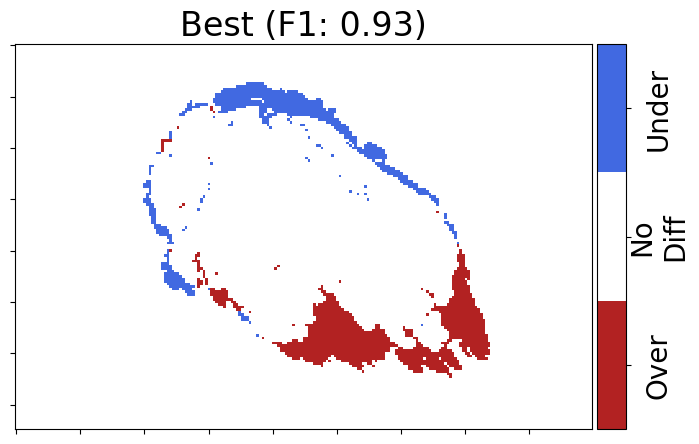

In [528]:
# Plot best result (by F1)

# Plot
fig, ax = plt.subplots(1, figsize=(8,5))

scalebar = ScaleBar(scale_size, 'm', length_fraction=scale_length_fraction, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": label_size})
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = df_farsite[:150, 50:275] - np.array(df_result)[:150, 50:275]
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
# ax[i].add_artist(scalebar)
ax.set_xticklabels([]);ax.set_yticklabels([])
ax.set_title("{} (F1: {:.2f})".format(title, F1), size=24)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No\nDiff','Over'],size=label_size, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

plt.tight_layout
plt.show()